# Laboratorium 6

Rozwiązywanie układów równań liniowych

In [1]:
import numpy.linalg as nplin # lin.solve lin.lstsq
import scipy.linalg as sclin # lin.lu
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

## 1. Gauss–Jordan elimination

Napisz i sprawdź funkcję rozwiązującą układ równań liniowych $n\times n$ metodą Gaussa-Jordana. Dla rozmiarów macierzy współczynników większych niż $500\times500$ porównaj
czasy działania zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji
bibliotecznych.

In [2]:
def generatematrix(n, val=1e6, m=None):
    return np.random.uniform(-val,val,size=(n,m if m else n))

Generowanie macierzy o danym rozmiarze wartościami o zadanym zakresie.

In [3]:
def scalematrix(M):
    return M/np.max(M[:, :-1], axis=1, keepdims=True)

Skalujemy macierz, żeby w każdym wierszu największą wartością współczynnika (czyli poza ostatnią kolumną) była 1.

In [4]:
def partialpivoting(M):
    for i in range(len(M)):
        ix = i
        mx = abs(M[i][i])
        for k in range(i+1, len(M)):
            if abs(M[i][k])>mx:
                mx = abs(M[i][k])
                ix=k
        M[[i, ix]]=M[[ix, i]]
    return M

Nie było sprecyzowane jaki i czy w ogóle używać pivotingu. Wybrałem opcję pośrednią - pivoting częściowy.\
Chcemy, aby na miejscu [i,i] w macierzy, była możliwie jak najbardziej różna wartość od 0.

In [5]:
def gaussjord(A, Y):
    M=np.hstack((A,Y))
    M = partialpivoting(scalematrix(M))
    
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            if i==j:
                continue
            M[j] *= (M[i][i]/M[j][i]) # przeskalowanie wiersza
            M[j] -= M[i]
            M[j][i] = 0. # dla pewności, ze względu na błędy numeryczne przy liczbach zmiennoprzecinkowych
    
    res=[]
    for i in range(M.shape[0]):
        res.append([M[i][-1]/M[i][i]])
    
    return np.array(res)

Metodą Gaussa-Jordana tworzymy macierz diagonalną (sama metoda Gaussa-Jordana sprowadza tylko do macierzy diagonalnej, ale żeby rozwiązać układ równań i sobie ułatwić zadanie możemy ją bardzo łatwo rozszerzyć i za każdym razem odejmować swój przeskalowany odpowiednio wiersz od wszystkich pozostałych).

In [6]:
gaussjord(generatematrix(5, 10), generatematrix(5, 10, 1))

array([[-5.96448209],
       [ 1.68259387],
       [ 0.30096522],
       [ 1.89611223],
       [ 0.64382849]])

Przetestujmy działanie napisanej funkcji.\
Wykorzystamy do tego funkcję solve i lstsq z pakietu numpy.linalg .

In [7]:
def tstgj(n=100, val=1e6, err=1e-7):
    A, Y = generatematrix(n, val), generatematrix(n, val, 1)
    sol=gaussjord(A, Y)
    dif=abs(nplin.solve(A, Y)-sol) + abs(nplin.lstsq(A, Y, rcond=-1)[0]-sol)
    if np.all(dif<err):
        return True
    else:
        print(max(dif))
        return False

Generujemy losowe macierze, o wartościach w podanym zakresie i sprawdzamy czy nasze rozwiązanie odbiega od bibliotecznego bardziej niż zadany błąd.

In [8]:
print(tstgj())
print(tstgj(500, 1e12))
for i in range(100):
    if not tstgj():
        print(f"Yikes {i}")
    print(i, end='\r')
print("all")

True
True
all


Wyniki są bardzo podobne, różnica jest zazwyczaj mniejsza niż 1e-7 (czasem trochę gorsza, ale dalej bardzo mała) więc bardzo dokładnie jak dla wartości z zakresu [1e-6, 1e6].

Porównajmy czasy wykonania, dla funkcji napisanej i bibliotecznej, dla macierzy większych niż $500\times500$.\
Znowu będę porównywał z funkcją solve z pakietu numpy.linalg .

In [9]:
def timgj(n=500, val=1e6):
    A, Y = generatematrix(n, val), generatematrix(n, val, 1)
    print("\n\tFunkcja biblioteczna solve dla n=%s:"%n)
    %timeit index = nplin.solve(A, Y)
    print("\n\tFunckja biblioteczna lstsq dla n=%s:"%n)
    %timeit index = nplin.lstsq(A,Y,rcond=-1)
    print("\n\t Funkcja napisana dla n=%s:"%n)
    %timeit index = gaussjord(A, Y)
    print("\n")

In [10]:
timgj()
timgj(750)
timgj(1000)


	Funkcja biblioteczna solve dla n=500:
11.9 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

	Funckja biblioteczna lstsq dla n=500:
183 ms ± 61.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

	 Funkcja napisana dla n=500:
1.9 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



	Funkcja biblioteczna solve dla n=750:
The slowest run took 5.77 times longer than the fastest. This could mean that an intermediate result is being cached.
30.3 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

	Funckja biblioteczna lstsq dla n=750:
395 ms ± 92.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	 Funkcja napisana dla n=750:
3.92 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



	Funkcja biblioteczna solve dla n=1000:
30.4 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

	Funckja biblioteczna lstsq dla n=1000:
664 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	 Funkcja napisana 

Jak widać funkcje biblioteczne są dużo szybsze od napisanej eliminacji gaussa-jordana. Jest też znaczna różnica między funkcjami bibliotecznymi, z których numpy.linalg.solve jest zdecydowanie szybsza

## 2. LU Factorisation

Napisz i sprawdź funkcję dokonującą faktoryzacji A = LU macierzy A. Zastosuj częściowe poszukiwanie elementu wiodącego oraz skalowanie.

In [11]:
def LUdec(A):
    U = scalematrix(A.copy())
    L = np.zeros((A.shape[0], A.shape[0]))
    
    for i in range(A.shape[0]):
        L[i][i]=1.
        for j in range(i+1, A.shape[0]):
            L[j][i] = U[j][i]/U[i][i]
            U[j] -= U[i]*L[j][i]
            U[j][i] = 0.
    
    return L, U

Rozkładamy daną macierz, na dwie: L - z zerami nad przekątną i U - z zerami pod przekątną

In [12]:
A = scalematrix(generatematrix(5))
L, U = LUdec(A)
print(A)
print(L@U)
print(L)
print(U)
print(np.all(A-L@U<1e-7))

[[-0.96384825  0.386775    1.          0.89848542  0.4759548 ]
 [-0.3284489   0.76414158  0.44420808  1.         -0.89610305]
 [-0.89630926  0.31161006  0.73437488  1.          0.3475026 ]
 [-3.68984509 -0.88517293  0.67119828  1.          3.74669995]
 [ 0.09440178  1.         -0.85827146  0.28020132 -0.71524673]]
[[-0.96384825  0.386775    1.          0.89848542  0.4759548 ]
 [-0.3284489   0.76414158  0.44420808  1.         -0.89610305]
 [-0.89630926  0.31161006  0.73437488  1.          0.3475026 ]
 [-3.68984509 -0.88517293  0.67119828  1.          3.74669995]
 [ 0.09440178  1.         -0.85827146  0.28020132 -0.71524673]]
[[ 1.          0.          0.          0.          0.        ]
 [ 0.34076827  1.          0.          0.          0.        ]
 [ 0.92992777 -0.07600765  1.          0.          0.        ]
 [ 3.82824276 -3.7414018  14.7585095   1.          0.        ]
 [-0.09794258  1.64133252  4.95553672  0.60568188  1.        ]]
[[-0.96384825  0.386775    1.          0.89848542  0

In [13]:
def tstlu(n=500, val=1e6, err=1e-7):
    A = scalematrix(generatematrix(n))
    L, U = LUdec(A)
    res = L@U-A
    if np.all(res<err):
        return True
    else:
        print(max(res))
        return False

Testujemy czy z napisanej dekompozycji LU uzyskamy macierz startową

In [14]:
print(tstlu())
print(tstlu(500, 1e12))
for i in range(20):
    if not tstlu():
        print(f"Yikes {i}")
    print(i, end='\r')
print("all")


True
True
all


Jak widać LU dekompozycja działa dobrze i mieści się w zakresie błędu 1e-7, co dla zakresu danych [-1e6,1e6] jest bardzo dobrym wynikiem.

Z ciekawości porównajmy prędkości funkcji bibliotecznej i własnej implementacji.

In [15]:
A = scalematrix(generatematrix(500))
print("Funkcja biblioteczna rozmiar 500")
%timeit index = sclin.lu(A)
print("Funkcja własna rozmiar 500")
%timeit index = LUdec(A)
A = scalematrix(generatematrix(1000))
print("Funkcja biblioteczna rozmiar 1000")
%timeit index = sclin.lu(A)
print("Funkcja własna rozmiar 1000")
%timeit index = LUdec(A)

Funkcja biblioteczna rozmiar 500
9.46 ms ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Funkcja własna rozmiar 500
773 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Funkcja biblioteczna rozmiar 1000
51.4 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Funkcja własna rozmiar 1000
3.57 s ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Jak widać implementacja własna jest jednak dosyć wolniejsza od funkcji bibliotecznej.

## Analysis of electrical network

###### Napisz program który:
a) Wczytuje z pliku listę krawędzi obwodu elektrycznego. (Graf skierowany i ważony)\
b) Wczytuje między którymi węzłami i jaką siłę elektromotoryczną przyłożono.\
c) Wykorzystując praa Kirchoffa znajduje natężenie prądu w każdej częsci obwodu i przedstawia je na rysunku w postaci grafu ważonego z etykietami.\
e) Wykorzystując metodę potencjałów węzłowych zaimplementuj alternatywne rozwiązanie problemu.\
f) Przedstaw (wizualizacja + sprawdzenie poprawności wyników) działanie programu dla grafów spójnych mających od 15 do 100 wierzchołków:
- Spójny graf losowy
- Grad 3-regularny (kubiczny)
- Graf złożony z dwóch grafów losowych połączonych mostkiem
- Graf siatka 2D

In [16]:
def addres(G, r=100):
    for i, e in enumerate(G.edges):
        G.edges[e]['R']=random.randint(1,r)
        G.edges[e]['ix']=i
        G.edges[e]['I']=0
    return G

def randomgraph(n, e=0.5, r=100):
    G = nx.gnp_random_graph(n, e)
    while not nx.is_connected(G):
        G = nx.gnp_random_graph(n, e)
    return addres(G, r)

def randomcubic(n, r=100):
    return addres(nx.random_regular_graph(3, n), r)

def randombridge(n, r=100):
    s = random.randint(3, n-3)
    Gf = nx.gnm_random_graph(s, random.randint(s-1, s*(s-1)/2))
    while not nx.is_connected(Gf):
        Gf = nx.gnm_random_graph(s, random.randint(s-1, s*(s-1)/2))
    
    s=n-s
    Gs = nx.gnm_random_graph(s, random.randint(s-1, s*(s-1)/2))
    while not nx.is_connected(Gf):
        Gs = nx.gnm_random_graph(s, random.randint(s-1, s*(s-1)/2))
        
    G = nx.empty_graph(n)
    
    for e in Gf.edges:
        G.add_edge(*e)
        
    s=n-s
    for e in Gs.edges:
        G.add_edge(s+e[0], s+e[1])
        
    G.add_edge(random.randint(0, s-1), random.randint(s, n-1))
    return addres(G, r)

def randomgrid(x, y, r=100):
    tmp = nx.grid_2d_graph(x, y)
    while not nx.is_connected(tmp):
        tmp = nx.grid_2d_graph(x, y)
    
    nodes = {}
    G = nx.empty_graph()
    i=0
    for n in tmp.nodes:
        nodes[n]=i
        G.add_node(i)
        i+=1
    for n in nodes:
        for s in tmp.neighbors(n):
            if (nodes[n], nodes[s]) not in G:
                G.add_edge(nodes[n], nodes[s])
    return addres(G, r)

def save(G, s, t, e, name):
    with open(name, 'w') as f:
        f.write("%s %s\n%s %s %s\n"%(len(G.nodes), len(G.edges), s, t, e))
        for e in G.edges:
            f.write("%s %s %s\n"%(e[0], e[1], G.edges[e[0], e[1]]['R']))

def load(name):
    with open(name, 'r') as f:
        s, t, e = f.readline().split()
        V, E = f.readline().split()
        G = nx.empty_graph(V)
        for line in f.readlines():
            tmp = line.split()
            if len(tmp)!=3:
                continue
            G.add_edge(tmp[0], tmp[1], tmp[2])
        return G, s, t, e
    
def randomele(G, e=100):
    v = len(G.nodes)
    s = random.randint(0, v-1)
    t = random.randint(0, v-1)
    while s==t:
        t=random.randint(0, v-1)
    return s, t, random.randint(1, e)

def pri(G):
    for e in G.edges(data=True):
        print("Edge: %s - %s \t R=%s id=%s"%(e[0], e[1], e[2]['R'], e[2]['ix']))

In [17]:
# pri(randomgraph(10))
# pri(randomcubic(10))
# pri(randombridge(10))
# pri(randomgrid(2, 5))

In [18]:
# drawgraph(randomgraph(10), 1, 2)

Losowanie, czytanie, zapisywanie i wypisywanie grafów.

In [19]:
def drawgraph(G, s, t):
    pos = nx.spring_layout(G)
    colours = ['#6600CC' for i in range(len(G.nodes))]
    colours[s] = '#FF66B2'
    colours[t] = '#00FFFF'
    
    _, amp = zip(*nx.get_edge_attributes(G, 'I').items())
    
    lab = {}
    for k, v in nx.get_edge_attributes(G, 'I').items():
        lab[k] = "{0:.5f}".format(v)
        
    nx.draw_networkx_nodes(G, pos, node_color=colours)
    nx.draw_networkx_edges(G, pos, edge_color=amp, edge_cmap=plt.cm.Reds)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=lab)
    
    plt.show()

Rysowanie grafu wynikowego, z podpisami i kolorami (i zmienną intensywnością).

In [20]:
def direct(graph, s, t):
    G=nx.DiGraph()
    for i in range(len(graph.nodes)):
        G.add_node(i)
    for fr, to, data in graph.edges(data=True):
        if fr == t:
            fr, t = t, fr
        if to == s:
            to, s = s, to
        G.add_edge(fr, to)
        G.edges[(fr,to)]['R']=data['R']
        G.edges[(fr,to)]['I']=data['I']
        G.edges[(fr,to)]['ix']=data['ix']
    
    # usuniecie zbednych krawedzi i node'ow
    rem=set()
    components = nx.weakly_connected_components(G)
    for c in components:
        if s in c or t in c:
            continue
        rem |= c

    for n in rem:
#         print(n)
        G.remove_node(n)
        
    return G

In [21]:
# G=randomgraph(10)
# pri(G)
# print('\n')
# pri(direct(G))

In [28]:
def slv(graph, s, t, sem):
    G = direct(graph, s, t)
    R = np.zeros((len(G.edges), len(G.edges)))
    W = np.zeros(len(G.edges))
    
    eq=0
    for v in G.nodes:
        if eq>len(G.edges):
            break
        for e in G.out_edges(v):
            R[eq][G[e[0]][e[1]]['ix']] = 1
        for e in G.in_edges():
            R[eq][G[e[0]][e[1]]['ix']] = -1
        eq+=1
        
    cycles = nx.cycle_basis(G.to_undirected())
    for c in cycles:
        if eq>=len(G.edges):
            break
        pre=c[-1]
        for n in c:
            if pre == s and n == t:
                pre=n
                W[eq]=sem
                continue
            elif pre == t and n == s:
                pre=n
                W[eq]=-sem
                continue
            if (pre, n) in G.edges:
                R[eq][G[pre][n]['ix']]=G[pre][n]['R']
            else:
#                 print(c, n, pre)
                R[eq][G[n][pre]['ix']]=-G[n][pre]['R']
            pre=n
        eq+=1
        
#     print(R, W)
#     res=nplin.solve(R, W)
    for e in G.edges:
        G[e[0]][e[1]]['R']=res[G[e[0]][e[1]]['ix']]
    return G

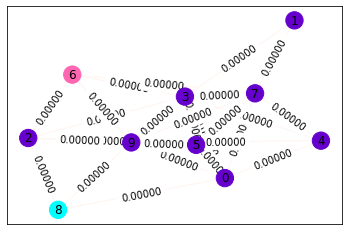

In [29]:
G=randomgraph(10)
st, end, ele = randomele(G)
# pri(G)
# print(nx.cycle_basis(G))
# res=slv(G, st, end, ele)
drawgraph(G, st, end)

In [24]:
# def slv(graph, s, t, sem):
#     V, E = len(graph.nodes), len(graph.edges)
#     G=direct(graph)
#     M = []
#     W = []
#     eq=0
    
#     for i in range(V):
#         if i==s or i==t or i>=E:
#             continue
#         r = np.zeros(E)
#         for e in G.in_edges(i, data=True):
#             r[e[2]['ix']] = 1
#         for e in G.out_edges(i, data=True):
#             r[e[2]['ix']] = -1
#         eq += 1
#         M.append(r)
#         W.append(0)
    
#     r = np.zeros(E)
#     for e in G.out_edges(s, data=True):
#         r[e[2]['ix']] = -1
#     for e in G.in_edges(t, data=True):
#         r[e[2]['ix']] = 1
    
#     W.append(0)
#     M.append(r)
#     eq+=1
    
#     print(eq)
    
#     cycles = nx.cycle_basis(G.to_undirected())
#     for c in cycles:
# #         print(c)
#         r=np.zeros(E)
#         prev = c[0]
#         for n in c[1:]:
# #             print(st, n)
#             if G.has_edge(prev, n):
#                 r[G[prev][n]['ix']] = G[prev][n]['R']
#             else:
#                 r[G[n][prev]['ix']] = -G[n][prev]['R']
#             prev=n
#         W.append(0)
#         M.append(r)
#         eq += 1
#     print(eq)
#     paths = nx.all_simple_paths(G, s, t)
#     for p in paths:
#         r = np.zeros(E)
#         prev = p[0]
#         for ob in p[1:]:
#             r[G[prev][ob]['ix']] = G[prev][ob]['R']
#             prev=ob
#         M.append(r)
#         W.append(sem)
#         eq += 1
#         if eq>E:
#             break
#     print(eq)
#     M=np.array(M)
#     W=np.array(W)
#     res = nplin.inv(M.T @ M) @ M.T  @ W
#     print(W)
#     for ix, e in enumerate(G.edges):
#         G.edges[e]['I'] = res[i]
        
#     return G

In [25]:
# G=randomgraph(10)
# st, end, ele = randomele(G)
# print(nx.cycle_basis(G))
# res=slv(G, st, end, ele)
# drawgraph(G, st, end)